<a href="https://colab.research.google.com/github/kenny-vb244/data-center-prediction/blob/main/ProjectData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

# ----------------------------
# 1. Load Data
# ----------------------------
afr_files = pd.read_csv('/content/drive/MyDrive/Project Data/Africa_countries_WUE_data.csv')
ai_files = pd.read_csv('/content/drive/MyDrive/Project Data/artificialanalysis_environmental.csv')

drought_files = pd.read_csv('/content/drive/MyDrive/Project Data/tx_drought_monitor.csv')
reservoir_files = pd.read_csv('/content/drive/MyDrive/Project Data/statewidereservoirsdata.csv', comment='#')
water_files = pd.read_csv('/content/drive/MyDrive/Project Data/officialwateruse.csv', skiprows=2)

afr_files = afr_files.drop(columns=['Unnamed: 0'], errors='ignore')


# ----------------------------
# 2. Clean water use numeric columns
# ----------------------------
columns_to_clean = ['Total_Groundwater', 'Total_SurfaceWater', 'Total_Reuse']

for col in columns_to_clean:
    if col in water_files.columns:
        water_files[col] = (
            water_files[col]
            .astype(str)
            .str.replace(",", "", regex=False)
        )
        water_files[col] = pd.to_numeric(water_files[col], errors="coerce")


# ----------------------------
# 3. Clean drought file
# ----------------------------
drought_files = drought_files.rename(columns={
    'period': 'Date',
    'None': 'No Drought',
    'D0': 'Abnormally Dry',
    'D1': 'Moderate',
    'D2': 'Severe',
    'D3': 'Extreme',
    'D4': 'Exceptional'
})

drought_files['Date'] = pd.to_datetime(drought_files['Date'])
drought_files['Year'] = drought_files['Date'].dt.year


# ----------------------------
# 4. Clean water file column names
# ----------------------------
water_files.columns = (
    water_files.columns
        .str.strip()
        .str.replace('\ufeff', '', regex=False)
)

columns_to_drop = [
    'RWP27DraftDataTimestamp', 'Total_Groundwater2', 'Textbox28', 'Textbox29',
    'Textbox27', 'Textbox22', 'Textbox23', 'Total_Groundwater1',
    'Total_SurfaceWater1', 'Total_Reuse1', 'Region_Totals1'
]

existing_cols = [c for c in columns_to_drop if c in water_files.columns]
water_files = water_files.drop(columns=existing_cols, errors='ignore')

water_files['Year'] = pd.to_numeric(water_files['Year'], errors='coerce')


# ----------------------------
# 5. Clean reservoir dataset
# ----------------------------
reservoir_files['Date'] = pd.to_datetime(reservoir_files['date'], errors='coerce')
reservoir_files['Year'] = reservoir_files['Date'].dt.year

# Keep only 2000+
reservoir_files = reservoir_files[reservoir_files['Year'] >= 2000]

# Average percent_full per year
reservoir_yearly = (
    reservoir_files.groupby("Year")['percent_full']
    .mean()
    .reset_index()
)


# ----------------------------
# 6. Aggregate water use per year
# ----------------------------
water_files['Total_Water_Use'] = (
    water_files[['Total_Groundwater', 'Total_SurfaceWater', 'Total_Reuse']]
    .sum(axis=1)
)

water_yearly = (
    water_files.groupby("Year")['Total_Water_Use']
    .sum()
    .reset_index()
)


# ----------------------------
# 7. Compute drought score per year
# ----------------------------
drought_scores_map = {
    'No Drought': 0,
    'Abnormally Dry': 1,
    'Moderate': 2,
    'Severe': 3,
    'Extreme': 4,
    'Exceptional': 5
}

drought_files['Drought_Score'] = (
    drought_files['No Drought'] * 0 +
    drought_files['Abnormally Dry'] * 1 +
    drought_files['Moderate'] * 2 +
    drought_files['Severe'] * 3 +
    drought_files['Extreme'] * 4 +
    drought_files['Exceptional'] * 5
) / 100  # drought values are percentages

drought_yearly = (
    drought_files.groupby("Year")['Drought_Score']
    .mean()
    .reset_index()
)


# ----------------------------
# 8. Merge all three datasets by Year
# ----------------------------
water_combo = (
    drought_yearly
        .merge(water_yearly, on="Year", how="outer")
        .merge(reservoir_yearly, on="Year", how="outer")
)


# ----------------------------
# 9. Forward-fill then Back-fill
# ----------------------------
numerical_cols = water_combo.select_dtypes(include=np.number).columns
water_combo[numerical_cols] = water_combo[numerical_cols].ffill().bfill()


# ----------------------------
# 10. Final output
# ----------------------------
display(water_combo.head())


,Year,Drought_Score,Total_Water_Use,percent_full
0,2000,3.399656,16260115.0,71.373497
1,2001,1.509969,16251072.0,80.159726
2,2002,1.506098,16266977.0,80.092055
3,2003,1.438031,15133742.0,80.490685
4,2004,0.571692,15495029.0,84.349727


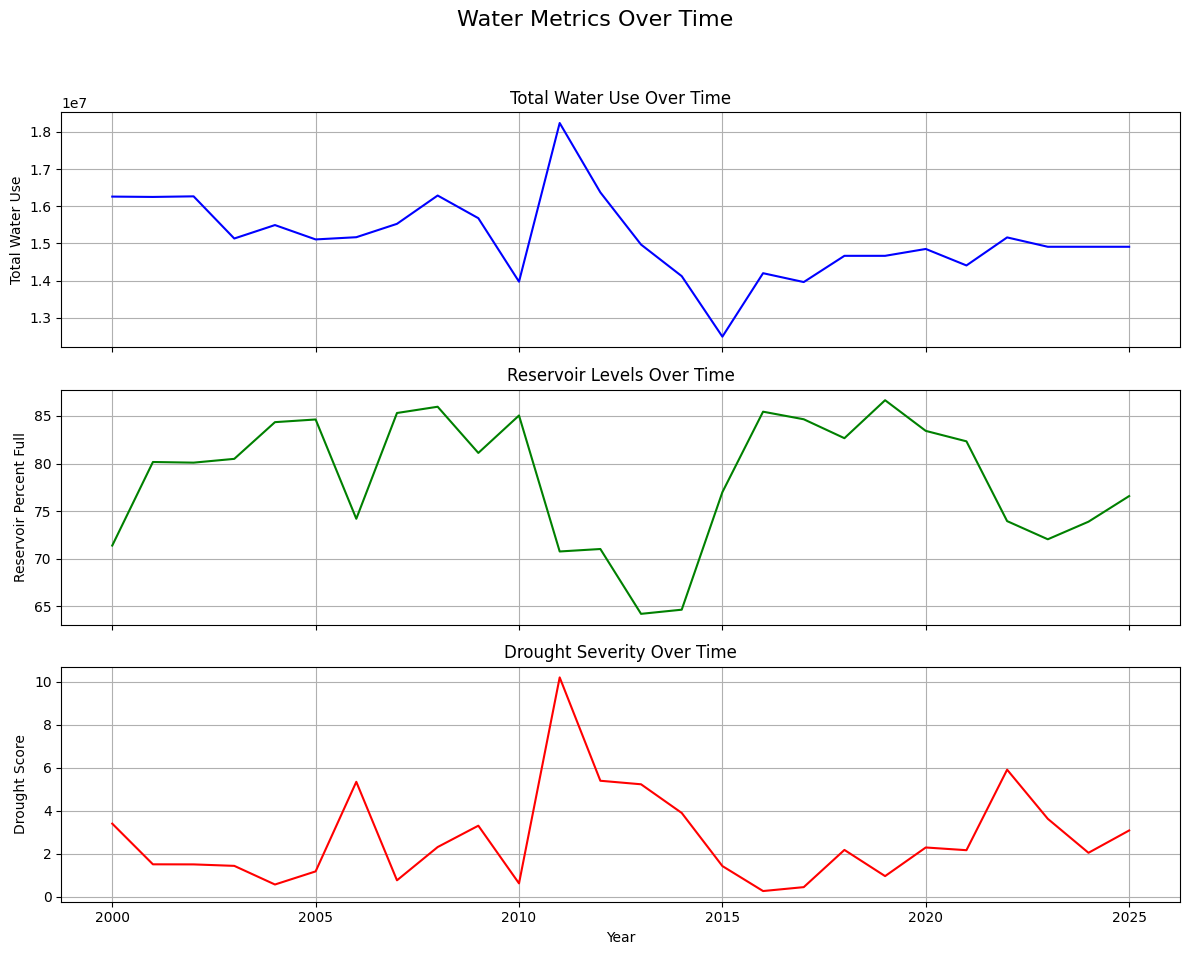

In [2]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)

# Plot Total_Water_Use
axes[0].plot(water_combo['Year'], water_combo['Total_Water_Use'], color='blue')
axes[0].set_ylabel('Total Water Use')
axes[0].set_title('Total Water Use Over Time')
axes[0].grid(True)

# Plot percent_full
axes[1].plot(water_combo['Year'], water_combo['percent_full'], color='green')
axes[1].set_ylabel('Reservoir Percent Full')
axes[1].set_title('Reservoir Levels Over Time')
axes[1].grid(True)

# Plot Drought_Score
axes[2].plot(water_combo['Year'], water_combo['Drought_Score'], color='red')
axes[2].set_ylabel('Drought Score')
axes[2].set_title('Drought Severity Over Time')
axes[2].set_xlabel('Year')
axes[2].grid(True)

# Set overall title for the figure
fig.suptitle('Water Metrics Over Time', fontsize=16)

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()

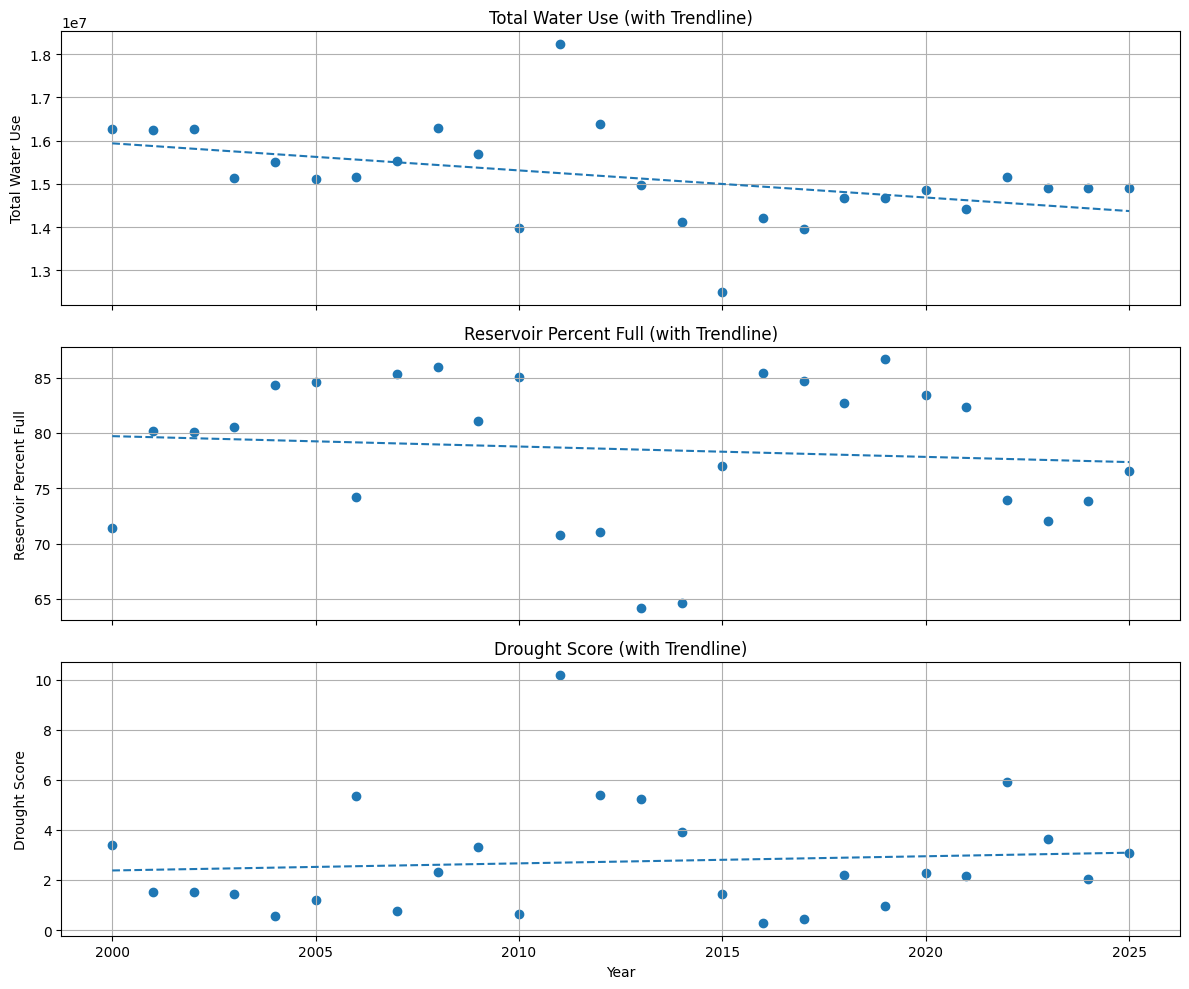

In [18]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

metrics = [
    ('Total_Water_Use', 'Total Water Use'),
    ('percent_full', 'Reservoir Percent Full'),
    ('Drought_Score', 'Drought Score')
]

for i, (col, label) in enumerate(metrics):
    x = water_combo['Year']
    y = water_combo[col]

    # Scatter
    axes[i].scatter(x, y)

    # Trend line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    axes[i].plot(x, p(x), linestyle='--')

    axes[i].set_title(f'{label} (with Trendline)')
    axes[i].set_ylabel(label)
    axes[i].grid(True)

axes[-1].set_xlabel('Year')

plt.tight_layout()
plt.show()


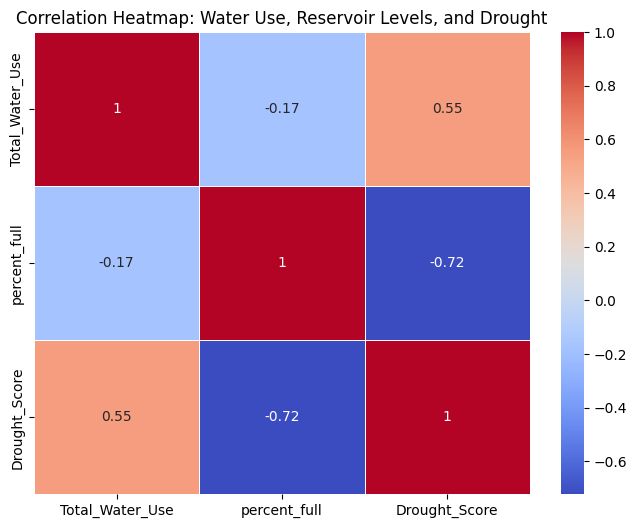

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only the numeric columns you want to compare
corr_data = water_combo[['Total_Water_Use', 'percent_full', 'Drought_Score']]

# Compute correlation matrix
corr_matrix = corr_data.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.title('Correlation Heatmap: Water Use, Reservoir Levels, and Drought')
plt.show()


In [20]:
import statsmodels.api as sm

X = water_combo['Drought_Score']
y = water_combo['percent_full']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           percent_full   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     26.14
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           3.12e-05
Time:                        06:49:20   Log-Likelihood:                -76.167
No. Observations:                  26   AIC:                             156.3
Df Residuals:                      24   BIC:                             158.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            84.3928      1.472     57.332

In [22]:
from scipy.stats import pearsonr

pearsonr(water_combo['Total_Water_Use'], water_combo['Drought_Score'])


PearsonRResult(statistic=np.float64(0.550165124180012), pvalue=np.float64(0.003591949860980494))

In [3]:
water_combo.to_csv('Water_Metrics.csv', index=False)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

water_metrics = pd.read_csv('/content/Water_Metrics.csv')

# Choose your feature matrix and target
X = water_metrics.drop(columns=['Total_Water_Use', 'Drought_Score', 'percent_full'])
y = water_metrics['Total_Water_Use']   # change for other targets

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Support Vector Regressor": SVR(),
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append([name, mae, rmse, r2])

df_results = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2 Score"])
print(df_results)


                      Model           MAE          RMSE  R2 Score
0         Linear Regression  1.114865e+06  1.472168e+06 -0.347543
1             Random Forest  1.145468e+06  1.646744e+06 -0.686087
2  Support Vector Regressor  1.245173e+06  1.608061e+06 -0.607804


In [5]:
#VAR
import pandas as pd
from statsmodels.tsa.api import VAR

# Ensure correct columns
features = ['Total_Water_Use', 'Drought_Score', 'percent_full']
df = water_metrics[['Year'] + features].sort_values('Year').reset_index(drop=True)

def forecast_var(df, features, steps=20, maxlags=3):
    # Time-series data matrix
    df_ts = df[features]

    # Fit VAR model
    model = VAR(df_ts)
    model_fit = model.fit(maxlags=maxlags)

    # Use last `model_fit.k_ar` rows as starting values
    lag_order = model_fit.k_ar
    last_values = df_ts.values[-lag_order:]

    # Forecast
    forecast = model_fit.forecast(last_values, steps=steps)

    # Create forecast DataFrame
    future_years = pd.Series(range(df['Year'].max() + 1,
                                   df['Year'].max() + steps + 1))

    forecast_df = pd.DataFrame(forecast, columns=features)
    forecast_df['Year'] = future_years

    return forecast_df

var_forecast = forecast_var(df, features, steps=20)
print("VAR Forecast for Next 20 Years")
display(var_forecast)


VAR Forecast for Next 20 Years


,Total_Water_Use,Drought_Score,percent_full,Year
0,1.452909e+07,1.135780,82.778825,2026
1,1.474868e+07,1.469321,82.993126,2027
2,1.487466e+07,2.477297,80.872522,2028
3,1.499472e+07,2.501719,81.163767,2029
4,1.534249e+07,3.215802,79.937452,2030
5,1.529288e+07,3.453548,77.896299,2031
6,1.510849e+07,3.402233,76.465407,2032
7,1.502590e+07,3.372977,76.148382,2033
8,1.488468e+07,2.921768,77.155029,2034
9,1.476681e+07,2.584242,78.091722,2035


In [6]:
#Recursive Random Forest
from sklearn.ensemble import RandomForestRegressor

def forecast_rf_recursive(df, features, steps=20):
    df_model = df.copy()
    predictions = {feat: [] for feat in features}

    for step in range(steps):
        X = df_model[features].shift(1).bfill()
        y = df_model[features]

        next_preds = {}
        for feat in features:
            model = RandomForestRegressor(
                n_estimators=200, random_state=42
            )
            model.fit(X.iloc[:-1], y[feat].iloc[1:])

            next_val = model.predict(X.iloc[[-1]])[0]
            next_preds[feat] = next_val
            predictions[feat].append(next_val)

        # Append predicted year to df_model
        df_model = pd.concat([df_model, pd.DataFrame([next_preds])],
                             ignore_index=True)

    future_years = pd.Series(
        range(df['Year'].max() + 1, df['Year'].max() + steps + 1)
    )

    rf_forecast = pd.DataFrame(predictions)
    rf_forecast["Year"] = future_years
    return rf_forecast


features = ['Total_Water_Use', 'percent_full']
rf_forecast = forecast_rf_recursive(df, features, steps=20)

In [7]:
#Recursive LSTM

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import LSTM, Dense, Input

def forecast_lstm_recursive(df, features, steps=20, epochs=200):
    df_model = df.copy()

    # -----------------------------
    # 1. SCALE THE DATA
    # -----------------------------
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(df_model[features])
    df_scaled = pd.DataFrame(scaled_values, columns=features)

    # -----------------------------
    # 2. CREATE LAGGED TRAINING DATA
    # -----------------------------
    X = df_scaled.shift(1).bfill().values[:-1]   # X(t-1)
    y = df_scaled.values[1:]                     # y(t)

    # reshape for LSTM: (samples, timesteps=1, features)
    X_lstm = X.reshape((X.shape[0], 1, X.shape[1]))

    # -----------------------------
    # 3. TRAIN SEPARATE LSTMs FOR EACH TARGET FEATURE
    # -----------------------------
    models = {}
    for idx, feat in enumerate(features):

        # target is the column index of "feat"
        y_feat = y[:, idx]

        # build model
        inputs = Input(shape=(1, len(features)))
        lstm = LSTM(50, activation="tanh")(inputs)
        outputs = Dense(1)(lstm)
        model = Model(inputs, outputs)

        model.compile(optimizer="adam", loss="mse")
        model.fit(X_lstm, y_feat, epochs=epochs, verbose=0)

        models[feat] = model

    # -----------------------------
    # 4. RECURSIVE MULTI-STEP FORECASTING
    # -----------------------------
    predictions_scaled = {feat: [] for feat in features}

    # start with last known scaled row
    current_input = df_scaled.iloc[[-1]].values  # shape (1, n_features)

    for step in range(steps):
        next_step_scaled = {}

        # LSTM expects (1, 1, n_features)
        X_pred = current_input.reshape(1, 1, len(features))

        for feat in features:
            model = models[feat]
            pred_val = model.predict(X_pred, verbose=0)[0][0]
            next_step_scaled[feat] = pred_val
            predictions_scaled[feat].append(pred_val)

        # feed prediction back into next iteration
        current_input = np.array([list(next_step_scaled.values())])

    # -----------------------------
    # 5. INVERSE TRANSFORM FORECASTS
    # -----------------------------
    scaled_df = pd.DataFrame(predictions_scaled, columns=features)
    unscaled = scaler.inverse_transform(scaled_df)

    forecast = pd.DataFrame(unscaled, columns=features)
    forecast["Year"] = range(df["Year"].max()+1, df["Year"].max()+steps+1)

    return forecast

features = ['Total_Water_Use', 'Drought_Score', 'percent_full']
#lstm_forecast = forecast_lstm_recursive(df, features, steps=20)
#print("LSTM Forecast for Next 20 Years")
#display(lstm_forecast)

lstm_drought = forecast_lstm_recursive(df, ['Drought_Score'], steps=20)


In [8]:
#VAR error metrics

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

features = ['Total_Water_Use', 'Drought_Score', 'percent_full']

df = water_metrics[['Year'] + features].sort_values('Year').reset_index(drop=True)
df_ts = df[features].copy()

from statsmodels.tsa.api import VAR

results_var = {col: {'mae': [], 'rmse': [], 'mape': []} for col in features}

start_train = 10   # first 10 years as training window
horizon = 1        # 1-step ahead forecast

for i in range(start_train, len(df) - horizon):

    # Split data
    train = df_ts.iloc[:i]
    test = df_ts.iloc[i:i+horizon]

    # Fit VAR
    model = VAR(train)
    model_fit = model.fit(maxlags=3)

    # Use correct lag order
    lag_order = model_fit.k_ar
    last_values = train.values[-lag_order:]

    # Forecast
    pred = model_fit.forecast(last_values, steps=horizon)
    pred_df = pd.DataFrame(pred, columns=features)

    # Compute error per column
    for col in features:
        y_true = test[col].values
        y_pred = pred_df[col].values

        results_var[col]['mae'].append(mean_absolute_error(y_true, y_pred))
        # Calculate RMSE by taking the square root of MSE
        results_var[col]['rmse'].append(np.sqrt(mean_squared_error(y_true, y_pred)))
        results_var[col]['mape'].append(mape(y_true, y_pred))

def summarize(results):
    summary = {}
    for col in results:
        summary[col] = {
            "MAE":  np.mean(results[col]['mae']),
            "RMSE": np.mean(results[col]['rmse']),
            "MAPE (%)": np.mean(results[col]['mape'])
        }
    return pd.DataFrame(summary).T

var_summary = summarize(results_var)

print("VAR Rolling Cross-Validation Error Summary")
display(var_summary)


VAR Rolling Cross-Validation Error Summary


,MAE,RMSE,MAPE (%)
Total_Water_Use,3.256981e+06,3.256981e+06,21.568697
Drought_Score,9.718486e+00,9.718486e+00,817.452161
percent_full,2.176986e+01,2.176986e+01,31.226017


In [9]:
import numpy as np

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.ensemble import RandomForestRegressor
import pandas as pd

def rolling_cv_rf(df, features, min_train_size=10):
    df = df.sort_values("Year").reset_index(drop=True)

    metrics = {feat: {"MAE": [], "RMSE": [], "MAPE (%)": []} for feat in features}

    for i in range(min_train_size, len(df)-1):
        train = df.iloc[:i]
        test = df.iloc[i:i+1]   # next-year true values

        # Lagged input (X = previous year values)
        X_train = train[features].shift(1).bfill()
        y_train = train[features]

        X_test = train[features].iloc[[-1]]  # predict year i using lagged data

        preds = {}

        # Fit one RF per feature
        for feat in features:
            model = RandomForestRegressor(
                n_estimators=200, random_state=42
            )
            model.fit(X_train.iloc[1:], y_train[feat].iloc[1:])

            preds[feat] = model.predict(X_test)[0]

        # True values
        true_vals = test[features].iloc[0]

        # Store metrics
        for feat in features:
            metrics[feat]["MAE"].append(abs(true_vals[feat] - preds[feat]))
            metrics[feat]["RMSE"].append((true_vals[feat] - preds[feat])**2)
            metrics[feat]["MAPE (%)"].append(
                abs((true_vals[feat] - preds[feat]) / true_vals[feat]) * 100
            )

    # Aggregate to one row per feature
    results = {
        feat: {
            "MAE": np.mean(metrics[feat]["MAE"]),
            "RMSE": np.sqrt(np.mean(metrics[feat]["RMSE"])),
            "MAPE (%)": np.mean(metrics[feat]["MAPE (%)"])
        }
        for feat in features
    }

    return pd.DataFrame(results).T

features = ['Total_Water_Use', 'Drought_Score', 'percent_full']

cv_results_rf = rolling_cv_rf(df, features)
print("Rolling Cross-Validation Results for Random Forest")
display(cv_results_rf)


Rolling Cross-Validation Results for Random Forest


,MAE,RMSE,MAPE (%)
Total_Water_Use,1.308070e+06,1.664559e+06,9.073896
Drought_Score,2.862567e+00,3.626203e+00,299.230963
percent_full,7.375616e+00,8.176374e+00,9.903579


In [10]:
#LSTM error metrics

def train_lstm_models(df, features, epochs=50):
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

    # Lagged X for training
    X_train = df_scaled.shift(1).bfill().values[:-1].reshape(-1, 1, len(features))

    trained_models = {}
    for feat in features:
        y_train = df_scaled[feat].values[1:]

        inputs = Input(shape=(1, len(features)))
        lstm_layer = LSTM(50, activation='tanh')(inputs)
        outputs = Dense(1)(lstm_layer)
        model = Model(inputs, outputs)

        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=epochs, verbose=0)

        trained_models[feat] = model

    return trained_models, scaler

def rolling_cv_lstm_per_feature(df, features, initial_train_years=10, forecast_horizon=1, epochs=5):
    """
    Rolling-origin CV for LSTM that returns MAE, RMSE, and MAPE PER FEATURE.
    """
    df_sorted = df.sort_values("Year").reset_index(drop=True)

    mae_scores = {f: [] for f in features}
    rmse_scores = {f: [] for f in features}
    mape_scores = {f: [] for f in features}

    min_year = df_sorted["Year"].min()
    max_year = df_sorted["Year"].max()

    for train_end_year in range(min_year + initial_train_years,
                                max_year - forecast_horizon + 1):

        train = df_sorted[df_sorted["Year"] <= train_end_year]
        test  = df_sorted[df_sorted["Year"] == train_end_year + forecast_horizon]

        if len(test) == 0:
            continue

        # Forecast 1 step
        pred_df = forecast_lstm_recursive(train, features, steps=forecast_horizon, epochs=epochs)
        pred = pred_df.iloc[-1][features]
        actual = test[features].iloc[0]

        # ---- FIXED: Convert all values to floats ----
        for f in features:
            y_true = float(actual[f])
            y_pred = float(pred[f])

            error = y_true - y_pred

            mae_scores[f].append(abs(error))
            rmse_scores[f].append(error**2)

            if y_true != 0:
                mape_scores[f].append(abs(error / y_true) * 100)

    # Aggregate into a clean table
    results = pd.DataFrame({
        "MAE": {f: np.mean(mae_scores[f]) for f in features},
        "RMSE": {f: np.sqrt(np.mean(rmse_scores[f])) for f in features},
        "MAPE (%)": {f: np.mean(mape_scores[f]) for f in features}
    })

    return results

lstm_feature_metrics = rolling_cv_lstm_per_feature(df, features)
lstm_feature_metrics



,MAE,RMSE,MAPE (%)
Total_Water_Use,1.894206e+06,2.074386e+06,12.534617
Drought_Score,2.743739e+00,3.688020e+00,79.070159
percent_full,1.149110e+01,1.345732e+01,14.345424


In [11]:
def combine_model_metrics(var_results, rf_results, lstm_results):
    """
    Combine the per-feature error metrics for VAR, RF, and LSTM
    into one multi-index DataFrame.
    """

    # Label each model
    var_labeled  = var_results.copy()
    var_labeled["Model"] = "VAR"

    rf_labeled   = rf_results.copy()
    rf_labeled["Model"] = "Random Forest"

    lstm_labeled = lstm_results.copy()
    lstm_labeled["Model"] = "LSTM"

    # Combine all into one table
    combined = pd.concat([var_labeled, rf_labeled, lstm_labeled])

    # Move model column to index
    combined = combined.set_index("Model")

    return combined

comparison_table = combine_model_metrics(
    var_summary,
    cv_results_rf,
    lstm_feature_metrics
)

comparison_table

#Random forest for water use and reservoir level
#LSTM for drought index

,MAE,RMSE,MAPE (%)
Model,,,
VAR,3.256981e+06,3.256981e+06,21.568697
VAR,9.718486e+00,9.718486e+00,817.452161
VAR,2.176986e+01,2.176986e+01,31.226017
Random Forest,1.308070e+06,1.664559e+06,9.073896
Random Forest,2.862567e+00,3.626203e+00,299.230963
Random Forest,7.375616e+00,8.176374e+00,9.903579
LSTM,1.894206e+06,2.074386e+06,12.534617
LSTM,2.743739e+00,3.688020e+00,79.070159
LSTM,1.149110e+01,1.345732e+01,14.345424


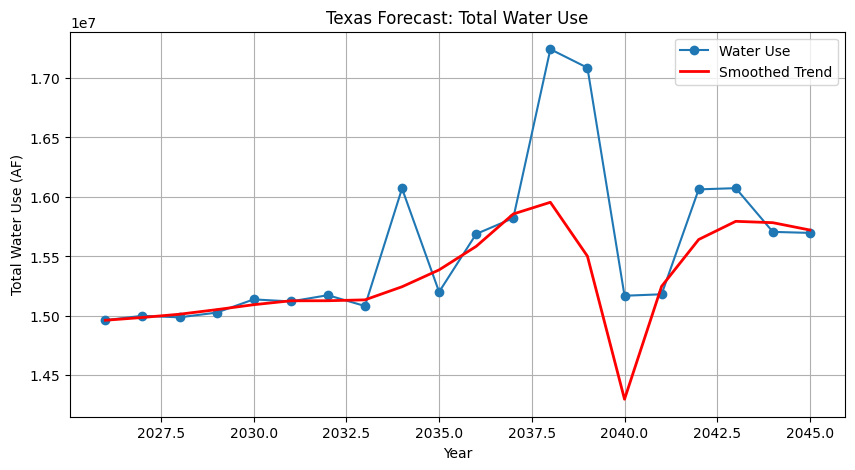

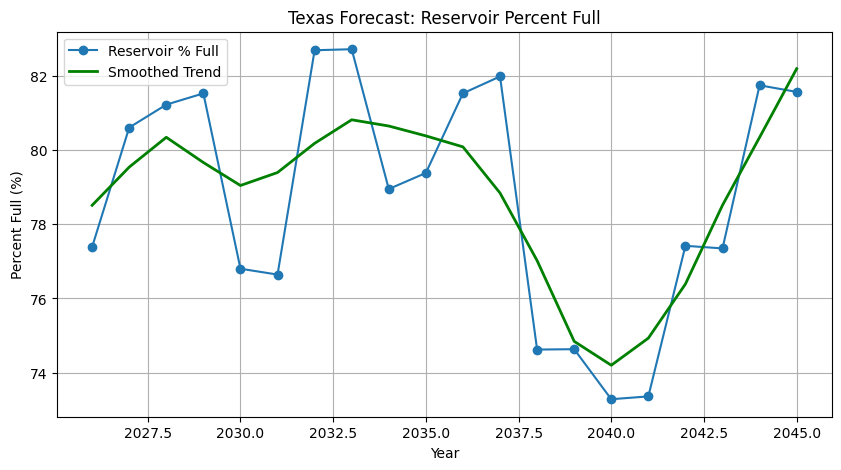

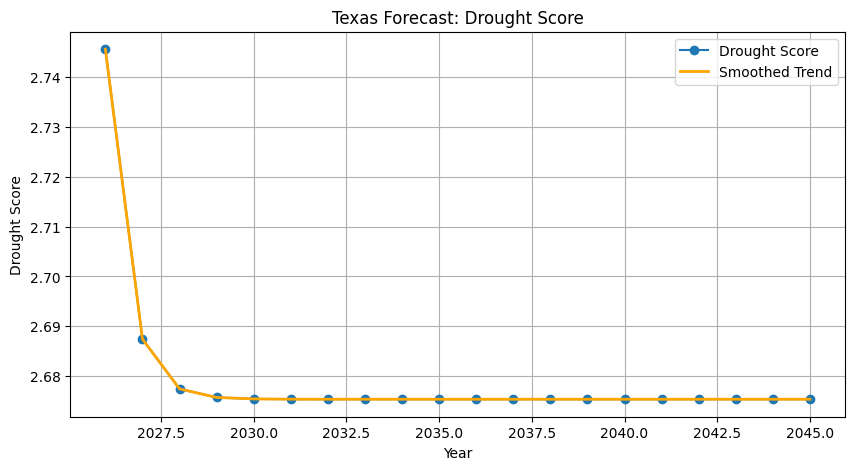

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

texas_forecast = pd.DataFrame()
texas_forecast['Year'] = rf_forecast['Year']
texas_forecast['Total_Water_Use'] = rf_forecast['Total_Water_Use']  # acre-feet
texas_forecast['percent_full'] = rf_forecast['percent_full']
texas_forecast['Drought_Score'] = lstm_drought['Drought_Score'].values

# --- Extract x-axis (Year) ---
years = texas_forecast['Year']

# --- 1) Water Use Plot ---
water_use = texas_forecast['Total_Water_Use']
water_smooth = lowess(water_use, years, frac=0.3)

plt.figure(figsize=(10, 5))
plt.plot(years, water_use, marker='o', linestyle='-', label='Water Use')
plt.plot(water_smooth[:, 0], water_smooth[:, 1], color='red', linewidth=2, label='Smoothed Trend')
plt.xlabel('Year')
plt.ylabel('Total Water Use (AF)')
plt.title('Texas Forecast: Total Water Use')
plt.legend()
plt.grid(True)
plt.show()


# --- 2) Reservoir Percent Full Plot ---
percent_full = texas_forecast['percent_full']
reservoir_smooth = lowess(percent_full, years, frac=0.3)

plt.figure(figsize=(10, 5))
plt.plot(years, percent_full, marker='o', linestyle='-', label='Reservoir % Full')
plt.plot(reservoir_smooth[:, 0], reservoir_smooth[:, 1], color='green', linewidth=2, label='Smoothed Trend')
plt.xlabel('Year')
plt.ylabel('Percent Full (%)')
plt.title('Texas Forecast: Reservoir Percent Full')
plt.legend()
plt.grid(True)
plt.show()


# --- 3) Drought Score Plot ---
drought = texas_forecast['Drought_Score']
drought_smooth = lowess(drought, years, frac=0.3)

plt.figure(figsize=(10, 5))
plt.plot(years, drought, marker='o', linestyle='-', label='Drought Score')
plt.plot(drought_smooth[:, 0], drought_smooth[:, 1], color='orange', linewidth=2, label='Smoothed Trend')
plt.xlabel('Year')
plt.ylabel('Drought Score')
plt.title('Texas Forecast: Drought Score')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
import pandas as pd

# --- Build Texas Forecast using RF + LSTM ---

texas_forecast = pd.DataFrame()
texas_forecast['Year'] = rf_forecast['Year']
texas_forecast['Total_Water_Use'] = rf_forecast['Total_Water_Use']  # acre-feet
texas_forecast['percent_full'] = rf_forecast['percent_full']
texas_forecast['Drought_Score'] = lstm_drought['Drought_Score'].values


# ==============================================================
# === A) IMPACT OF 500 NEW DATA CENTERS ========================
# ==============================================================

# 1. Mean combined water use per prompt (mL)
mL_per_prompt = ai_files['Mean Combined Water (Site & Source, mL)'].mean()

# 2. Assume a typical large DC runs ~100 million queries/day
#    → 36.5 billion queries/year
queries_per_year = 3.65e10

# 3. Annual water per data center (mL)
mL_per_datacenter_year = mL_per_prompt * queries_per_year

# 4. Convert to acre-feet (1 AF = 1,233,000 L = 1.233e9 mL)
AF_per_datacenter_year = mL_per_datacenter_year / 1.233e9

# 5. Add 500 data centers
texas_forecast['Extra_Water_500_DataCenters'] = (
    texas_forecast['Total_Water_Use'] + 500 * AF_per_datacenter_year
)



# ==============================================================
# === C) RESERVOIR IMPACT ESTIMATE =============================
# ==============================================================

# Change in water use
delta_500dc = texas_forecast['Extra_Water_500_DataCenters'] - texas_forecast['Total_Water_Use']

# Reservoir percent impact (percent_full decreases proportionally to additional use)
texas_forecast['Reservoir_pct_500DC'] = (
    texas_forecast['percent_full'] -
    (delta_500dc / texas_forecast['Total_Water_Use']) * 100
)




# ==============================================================
# === OUTPUT ====================================================
# ==============================================================

display(
    texas_forecast[
        [
            'Year', 'Total_Water_Use', 'percent_full',
            'Extra_Water_500_DataCenters',
            'Reservoir_pct_500DC',
        ]
    ]
)


,Year,Total_Water_Use,percent_full,Extra_Water_500_DataCenters,Reservoir_pct_500DC
0,2026,1.496409e+07,77.385124,1.524694e+07,75.494951
1,2027,1.500086e+07,80.600072,1.528370e+07,78.714532
2,2028,1.498792e+07,81.216327,1.527077e+07,79.329159
3,2029,1.502769e+07,81.519063,1.531054e+07,79.636890
4,2030,1.513880e+07,76.798863,1.542165e+07,74.930504
5,2031,1.512155e+07,76.641292,1.540440e+07,74.770801
6,2032,1.517413e+07,82.680522,1.545698e+07,80.816513
7,2033,1.508303e+07,82.708041,1.536587e+07,80.832772
8,2034,1.607113e+07,78.944256,1.635398e+07,77.184285
9,2035,1.520169e+07,79.377174,1.548453e+07,77.516544


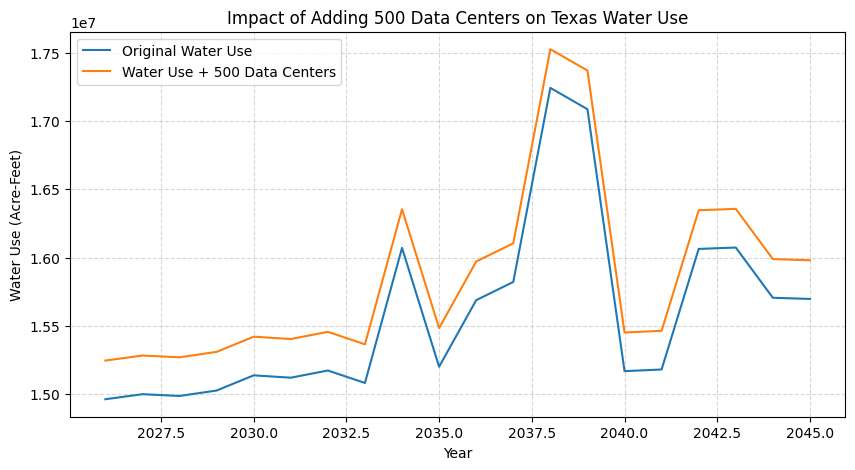

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(texas_forecast['Year'], texas_forecast['Total_Water_Use'], label='Original Water Use')
plt.plot(texas_forecast['Year'], texas_forecast['Extra_Water_500_DataCenters'], label='Water Use + 500 Data Centers')

plt.title("Impact of Adding 500 Data Centers on Texas Water Use")
plt.xlabel("Year")
plt.ylabel("Water Use (Acre-Feet)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()



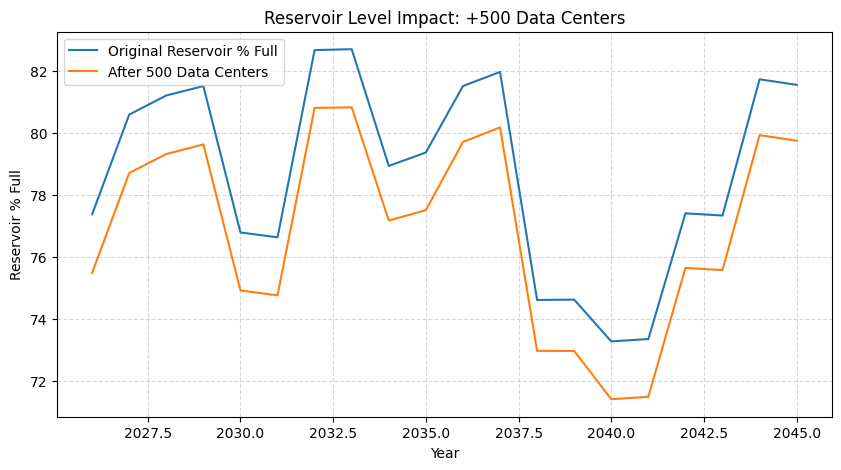

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(texas_forecast['Year'], texas_forecast['percent_full'], label='Original Reservoir % Full')
plt.plot(texas_forecast['Year'], texas_forecast['Reservoir_pct_500DC'], label='After 500 Data Centers')

plt.title("Reservoir Level Impact: +500 Data Centers")
plt.xlabel("Year")
plt.ylabel("Reservoir % Full")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


In [16]:
import pandas as pd

summary = pd.DataFrame({
    "Year": texas_forecast["Year"],

    # Percent loss = original percent_full − new percent_full
    "Loss_from_500_DC (%)": texas_forecast["percent_full"] - texas_forecast["Reservoir_pct_500DC"],

})

# Show table
summary


,Year,Loss_from_500_DC (%)
0,2026,1.890173
1,2027,1.885540
2,2028,1.887168
3,2029,1.882173
4,2030,1.868359
5,2031,1.870491
6,2032,1.864009
7,2033,1.875268
8,2034,1.759971
9,2035,1.860630


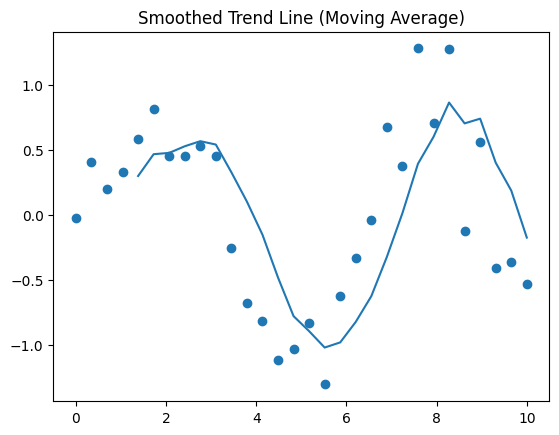

In [17]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 30)
y = np.sin(x) + np.random.normal(scale=0.3, size=len(x))

window = 5
y_smooth = np.convolve(y, np.ones(window)/window, mode='valid')

plt.scatter(x, y)
plt.plot(x[window-1:], y_smooth)
plt.title("Smoothed Trend Line (Moving Average)")
plt.show()
